In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D:/all_Bringal'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
inputs, classes = next(iter(dataloaders['train']))
print(classes)

tensor([1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 0,
        1, 2, 0, 1, 2, 2, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 1])


In [30]:
for x in classes:
    print(class_names[preds[j]])

tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


Visualize a few images ^^^^^^^^^^^^^^^^^^^^^^ Let's visualize a few training images so as to understand the data augmentations.

torch.Size([50, 3, 224, 224])
torch.Size([50])


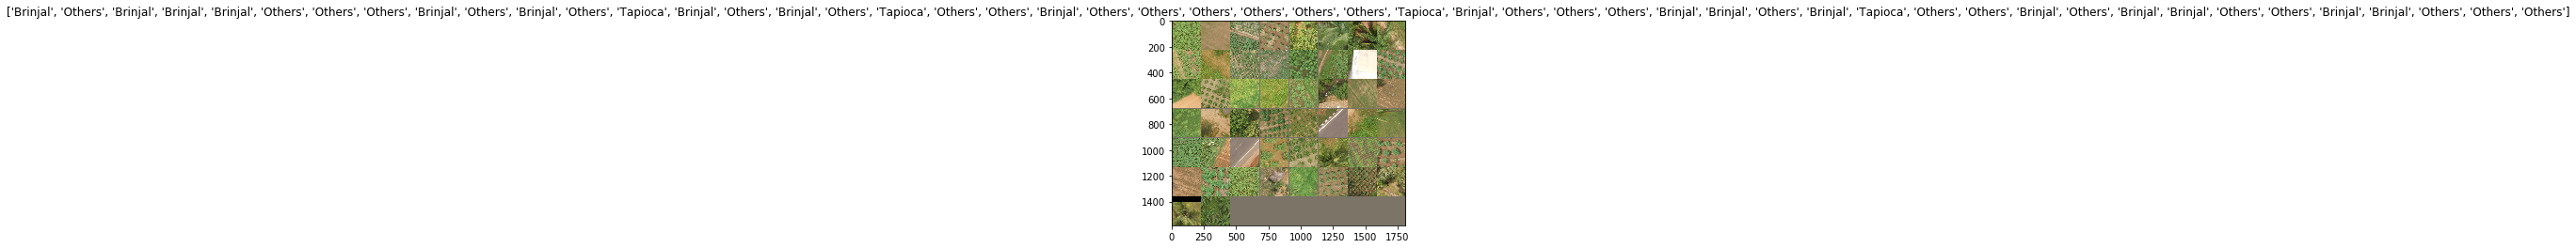

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
print(classes.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model
Now, let's write a general function to train a model.

. Scheduling the learning rate
. Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(),'weight_T.pth')
    return model

Visualizing the model predictions ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [3]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# Train and evaluate ^^^^^^^^^^^^^^^^^^

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
train Loss: 0.4881 Acc: 0.8116
val Loss: 0.1428 Acc: 0.9668

Epoch 1/5
----------
train Loss: 0.1680 Acc: 0.9440
val Loss: 0.0729 Acc: 0.9852

Epoch 2/5
----------
train Loss: 0.1066 Acc: 0.9678
val Loss: 0.0449 Acc: 0.9852

Epoch 3/5
----------
train Loss: 0.0843 Acc: 0.9739
val Loss: 0.0280 Acc: 0.9963

Epoch 4/5
----------
train Loss: 0.0587 Acc: 0.9846
val Loss: 0.0338 Acc: 0.9889

Epoch 5/5
----------
train Loss: 0.0612 Acc: 0.9809
val Loss: 0.0422 Acc: 0.9852

Training complete in 13m 28s
Best val Acc: 0.996310


In [14]:
pwd

'C:\\Users\\Rahul Prasad'

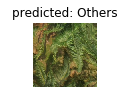

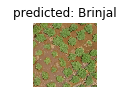

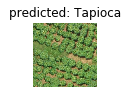

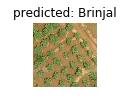

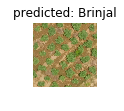

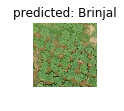

In [21]:
visualize_model(model_ft)

# Testing the Model


In [8]:
# Test the model
#was_training = model.training
model_ft.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(dataloaders['test']):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 120 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model_ft.state_dict(), 'conv_net_model11.ckpt')

# p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
# p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
# p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
# p.line(np.arange(len(loss_list)), loss_list)
# p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
# show(p)

Test Accuracy of the model on the 120 test images: 98.11320754716981 %


In [9]:
def visualize_model1(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

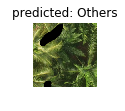

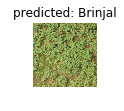

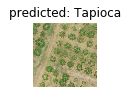

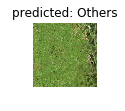

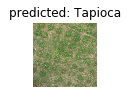

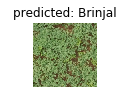

In [10]:
visualize_model1(model_ft)

In [4]:
net = model_ft.cuda()
net.load_state_dict(torch.load('weight_T.pth'))

In [5]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [10]:
# Test the model
#was_training = model.training
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(dataloaders['test']):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 120 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(net.state_dict(), 'conv_net_model11.ckpt')

# p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
# p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
# p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
# p.line(np.arange(len(loss_list)), loss_list)
# p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
# show(p)

Test Accuracy of the model on the 120 test images: 94.81132075471697 %


In [23]:
for i, (images, labels) in enumerate(dataloaders['test']):

    print(images.shape)
    #print(labels.size(0))

torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([12, 3, 224, 224])


In [6]:
import numpy as np
from scipy import signal
import skimage
import skimage.io as sio
from skimage import filters
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [66]:
image=Image.open("D://jio_kisan_120m//Patch1//ortho_res.tif")

print(image.size) #size is inverted i.e columns first rows second eg: 500,250

#convert to array
li_r=list(image.getdata(band=0))
arr_r=np.array(li_r,dtype="uint8")
li_g=list(image.getdata(band=1))
arr_g=np.array(li_g,dtype="uint8")
li_b=list(image.getdata(band=2))
arr_b=np.array(li_b,dtype="uint8")

# reshape 
reshaper=arr_r.reshape(7915,9611) #size flipped so it reshapes correctly
reshapeb=arr_b.reshape(7915,9611)
reshapeg=arr_g.reshape(7915,9611)

imr=Image.fromarray(reshaper,mode=None) # mode I
imb=Image.fromarray(reshapeb,mode=None)
img=Image.fromarray(reshapeg,mode=None)

#merge
merged=Image.merge("RGB",(imr,img,imb))
merged.save('D://jio_kisan_120m//Patch1//out.png')
merged.show()

(9611, 7915)


In [57]:
print(merged.size)

(9611, 7915)


Image Shape is: (7915, 9611, 3)


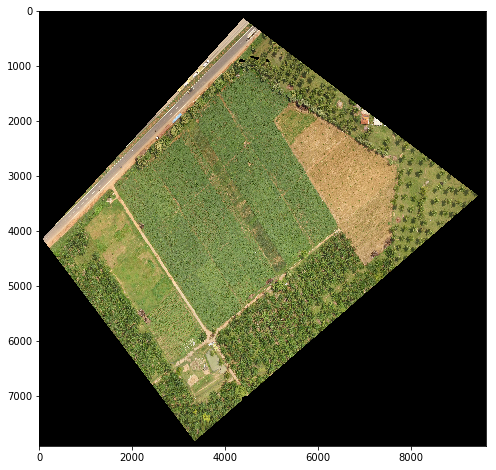

(<matplotlib.image.AxesImage at 0x1873e9a2a58>, None)

In [10]:
img = sio.imread('D://jio_kisan_120m//Patch1//out.png')
#img = skimage.color.rgb2gray(img)
print('Image Shape is:',img.shape)
plt.figure(figsize = (8,8))
plt.imshow(img,cmap='gray',aspect='auto'),plt.show()

In [11]:
input=(torch.randn(1,3,224,224)).to(device)
output=net(input)
print(output.size())

torch.Size([1, 3])


In [6]:
import numpy as np
from osgeo import gdal
#import sys
#import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.misc import toimage
import cv2
from PIL import Image, ImageEnhance
import time
from scipy.misc import imresize, imread, imshow

In [7]:
ds=gdal.Open("D:/jio_kisan_120m/Patch1/ortho_res.tif")
print("[RASTER BAND COUNT]:",ds.RasterCount)

[RASTER BAND COUNT]: 4


In [8]:
class Normalize(object):
    """
    Normalize an tensor image with mean and standard deviation.
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    Args:
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO: make efficient
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

In [9]:
R = ds.GetRasterBand(1).ReadAsArray()
G= ds.GetRasterBand(2).ReadAsArray()
B = ds.GetRasterBand(3).ReadAsArray()
r, g, b=R, G, B

print(R.shape, r.shape)

(23331, 28330) (23331, 28330)


In [10]:
kar_s=224
stride=224
kar = np.ones((kar_s,kar_s),np.uint8)

In [11]:
#####################PADDING##########################
########################RED PADDING#####################
r=np.concatenate((r,np.zeros((kar_s,r.shape[1]),dtype=int)),axis=0)
r=np.concatenate((r,np.zeros((r.shape[0],kar_s),dtype=int)),axis=1)

In [12]:
########################GREEN PADDING#####################
g=np.concatenate((g,np.zeros((kar_s,g.shape[1]),dtype=int)),axis=0)
g=np.concatenate((g,np.zeros((g.shape[0],kar_s),dtype=int)),axis=1)

In [13]:
########################BLUE PADDING#####################
b=np.concatenate((b,np.zeros((kar_s,b.shape[1]),dtype=int)),axis=0)
b=np.concatenate((b,np.zeros((b.shape[0],kar_s),dtype=int)),axis=1)

In [14]:
#####################PADDING##########################
########################RED PADDING#####################
r=np.concatenate((r,np.zeros((kar_s,r.shape[1]),dtype=int)),axis=0)
r=np.concatenate((r,np.zeros((r.shape[0],kar_s),dtype=int)),axis=1)
########################GREEN PADDING#####################
g=np.concatenate((g,np.zeros((kar_s,g.shape[1]),dtype=int)),axis=0)
g=np.concatenate((g,np.zeros((g.shape[0],kar_s),dtype=int)),axis=1)
########################BLUE PADDING#####################
b=np.concatenate((b,np.zeros((kar_s,b.shape[1]),dtype=int)),axis=0)
b=np.concatenate((b,np.zeros((b.shape[0],kar_s),dtype=int)),axis=1)

MemoryError: 

In [14]:
from PIL import Image
import numpy as np
im1 = np.zeros((r.shape[0],r.shape[1],3),'uint8')
#rgbArray = np.zeros((R.shape[0],R.shape[1],3),'uint8')
im1[..., 0] = r[0:r.shape[0],0:r.shape[1]]
im1[..., 1] = g[0:r.shape[0],0:r.shape[1]]
im1[..., 2] = b[0:r.shape[0],0:r.shape[1]]

In [15]:
def batch_rgb_to_bgr(batch):
    #print(batch.size())
    (r, g, b) = torch.chunk(batch, 3, 1)
    #print(r.size())
    batch1 = torch.cat((b, g, r),1)
    #print(batch1.size())
    return batch1

In [16]:
def check_class(top_class):
    if top_class == 0:
        return "Brinjal"
    elif top_class ==1:
        return "Others"
    else:
        return "Tapioca"

In [17]:
######################################YELLOW COLOR DETECTION MEDIAN################################
tic=time.time()
counter1 = 0
counter2 = 0
counter3 = 0
for i in range(0,im1.shape[0]-(kar_s-1),stride):
    print(i)
    for j in range(0,im1.shape[1]-(kar_s-1),stride):
        r_m1=im1[i:i+kar_s,j:j+kar_s]
        test = imresize(r_m1,(224,224,3))
        test = test.transpose(2,0,1) 
        test = np.reshape(test,(1,3,224,224)) 
        test = test.astype(np.float32)
        testPT = torch.from_numpy(test).float()
        testPT = batch_rgb_to_bgr(testPT) 
        testPT = torch.div(testPT,255.0)
        mn = [0.406,0.456,0.485]
        sd = [0.225,0.224,0.229]
        norm = Normalize(mn,sd) 
        testPT = norm(testPT)
        testPT = testPT.to(device)
        outputs = net(testPT)
        top_prob, predicted = torch.max(outputs.data, 1)
        rm = check_class(predicted)
        if rm == "Brinjal":
            counter1 = counter1 + 1
        elif rm == "Tapioca":
            counter2 = counter2 + 1
        else:
            counter3 = counter3 + 1
        print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", check_class(predicted)  )
        
toc=time.time ()
print("Counter1 Value = ", counter1)
print("Counter2 Value = ", counter2)
print("Counter3 Value = ", counter3)
print((toc-tic)/60)

0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
672
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([191.0191], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([254.1712], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([335.1819], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([295.5206], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([158.3774], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([114.6217], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([66.9204], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([154.8021], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([232.0560], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([180.8962], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([229.9189], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([161.7428], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([253.8952], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([153.459

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([280.6322], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([222.5844], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([242.2671], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([128.7307], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([157.0866], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-7.5706], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([116.9505], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([108.4351], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([218.2044], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([220.486

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
2912
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2

The model is  tensor([170.3216], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([230.9798], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([328.6261], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([297.7607], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([172.4108], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([193.4469], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([278.2417], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([311.0795], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([203.7944], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([226.9387], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([243.3078], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-10.5553], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-34.4484], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([9.3178

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
3584
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2

The model is  tensor([251.7493], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([191.9075], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([190.4144], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([120.8815], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([174.6547], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([145.4019], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([204.4790], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([127.0421], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([198.7144], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([162.38

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([210.7888], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([105.9582], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([119.5646], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([163.5320], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([178.1251], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([241.3021], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([204.0952], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([191.8988], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([120.0253], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-29.91

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([98.8335], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([46.3621], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([74.7255], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([44.4548], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([107.3591], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([113.9286], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([132.1521], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([71.5554], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-10.9649], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-0.5224], d

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([232.4653], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([318.3367], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([295.0163], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([231.3607], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([179.1175], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([140.7770], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([155.9320], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([256.4030], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([284.0692], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([241.2827], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([152.01

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([5.4027], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([44.9974], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([134.8015], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([99.9224], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([94.8473], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([39.9042], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([7.7937], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([46.7561], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([13.0497], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([13.7824], devic

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([133.4909], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([295.7727], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([77.8268], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([100.9835], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([162.8566], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([254.5796], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([222.9439], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([124.0755], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([98.4072], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([203.0815

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([272.8303], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([348.1729], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([173.2670], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([162.7070], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([214.6020], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([274.7001], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([199.9104], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([234.86

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([125.3877], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([73.7088], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([64.3100], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([95.5254], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([79.7445], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([69.6282], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([86.1149], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([4.8448], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([78.1472], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([60.4426], devic

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([112.9834], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([119.2487], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([259.0508], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([229.8459], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([105.7671], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([69.0235], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([89.0174], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([159.6695], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([247.3292], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([206.8943

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([332.2846], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([228.9956], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([124.7841], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([173.4985], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([271.7307], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([263.0110], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([231.6766], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([173.45

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([57.5909], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([24.7673], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([40.2368], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([88.1339], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([153.0262], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([105.6147], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([100.8289], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([126.8251], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([82.9829], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2.7778], de

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([58.7970], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([88.6017], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([28.2827], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29.9005], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([101.1794], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([36.5188], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([43.2600], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([86.2957], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([76.1254], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([40.2837], devi

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([268.5326], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([147.9149], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([130.9877], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([216.6459], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([312.7715], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([195.4428], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([187.5674], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([150.71

The model is  tensor([128.1924], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([145.6066], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([326.0630], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([318.0233], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([129.2315], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([64.4073], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([85.5701], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([61.0205], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([108.9076], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([71.2827], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([53.2710], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([166.1229], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([37.6278], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([44.7639], de

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
7168
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2

The model is  tensor([52.1500], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([35.0078], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([35.1291], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([16.8273], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.8228], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([13.8317], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([44.4996], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([12.3551], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([32.2484], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([12.7268], dev

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([234.9547], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([88.7941], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([145.3409], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([319.6797], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([228.9737], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([205.7268], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([191.4944], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([144.359

The model is  tensor([159.1516], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([246.5717], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([138.5295], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([171.6219], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([223.2010], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([145.2262], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([193.5437], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([155.0145], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([142.2728], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([147.54

The model is  tensor([39.5445], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([16.6223], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([60.2672], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([55.7643], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([138.3040], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([80.8811], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([116.5206], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([112.3437], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([162.0779], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([111.0425], 

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
7840
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2

The model is  tensor([39.5577], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([17.3676], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([65.7887], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([27.1864], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([44.3849], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29.4229], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([74.1966], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-11.8343], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([38.3853], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([72.0644], devi

The model is  tensor([278.1961], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([194.7318], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([148.0926], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([209.2425], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([221.3871], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([179.2729], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([147.4772], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([162.2525], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([219.1030], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-12.70

The model is  tensor([52.8947], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([40.5412], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([104.5943], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([119.0869], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([124.5182], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([122.5462], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([96.4623], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([240.2286], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([168.6063], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([231.2043]

The model is  tensor([68.6943], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([73.0264], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([59.2116], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([53.3706], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([89.7068], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([81.6563], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([133.4455], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([117.8486], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([67.8417], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2.2703], devi

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
8512
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2

The model is  tensor([66.2154], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([94.1751], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([53.4399], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([17.2965], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([56.7208], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([48.0544], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-20.9111], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([76.9846], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([113.7984], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([40.1971], dev

The model is  tensor([171.0542], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([174.2756], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([167.0971], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([196.1584], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([146.5256], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([180.5665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([79.1442], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([20.8625], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([135.9851], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([56.2429]

The model is  tensor([18.7576], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([73.3696], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([84.5853], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([79.9152], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([72.0290], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([48.4612], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([20.2193], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([46.3551], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([160.8926], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([113.5859], dev

The model is  tensor([39.2063], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([41.9662], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([107.6151], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([107.8631], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([161.3965], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([87.0112], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([97.8332], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-11.6175], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.4249], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([107.8688], 

The model is  tensor([304.7350], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
9184
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2

The model is  tensor([125.5762], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([67.0716], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([115.2981], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([1.9676], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([5.5374], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-15.7027], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([35.8361], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-11.3610], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([28.6241], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([71.5306], de

The model is  tensor([274.6887], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([196.4874], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([113.2371], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([119.4105], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([120.8445], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([83.8896], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([103.9164], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([34.3171], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([64.5709], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([120.9211]

The model is  tensor([88.4036], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([109.1885], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([68.0459], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([48.5594], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([1.7018], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([50.5756], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([101.5082], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([159.5350], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([158.8553], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([133.0316], d

The model is  tensor([51.9563], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([51.5670], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([70.5165], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29.3197], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([115.4423], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([49.1736], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([20.4680], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([62.6827], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([99.9506], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([59.3322], devi

The model is  tensor([211.1225], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([123.2355], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([244.8297], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([234.9316], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.5368], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([352.7502], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.7360], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
9856
The model is  tensor([2

The model is  tensor([51.0760], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([59.5949], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([112.3747], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([37.9809], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([21.9266], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([9.9694], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([1.6697], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([37.9495], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29.4431], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([20.8539], device

The model is  tensor([158.7064], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([214.2898], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([44.3785], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([121.2996], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([47.8693], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([86.3372], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([135.2189], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([121.2993], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([87.4882], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([25.9968], 

The model is  tensor([13.4512], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([120.4075], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([86.6827], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([86.1851], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([18.8316], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([54.6956], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([152.1572], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([176.8539], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([176.1212], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([156.4297], 

The model is  tensor([60.1047], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([8.0991], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([108.7302], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.4923], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([19.3589], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([18.1691], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([28.5291], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([41.3428], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([28.6729], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([78.2005], dev

The model is  tensor([171.3483], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([249.6304], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([187.6429], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([187.7193], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([231.4169], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([332.0989], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([50.6076], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([30.4639], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-23.4094], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([89.0965], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([44.3933], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([13.9716], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([38.5774], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([27.3321], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([2.1455], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([70.6486], dev

The model is  tensor([104.5074], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([73.2142], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([86.7108], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([24.9780], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([171.9816], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([66.0814], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([66.8254], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([126.4126], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([112.6824], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([70.4089],

The model is  tensor([87.2167], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([65.8494], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([71.8186], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([12.4553], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([80.7668], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([64.0474], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([75.3873], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([77.9513], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([15.7733], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([27.8721], devi

The model is  tensor([-34.7258], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([97.8528], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([61.1006], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-2.6406], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([37.5558], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([37.9998], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([20.3692], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([25.5476], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([54.0662], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-15.1443], de

The model is  tensor([161.8234], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([217.2749], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([351.1872], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([16.4621], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([23.5417], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([5.1107], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-15.3531], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([29.6485], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([4.9017], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([12.4257], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([4.8188], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-17.7142], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([87.2879], dev

The model is  tensor([62.6203], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([41.2059], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([120.7151], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([40.6060], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([65.8510], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([83.6395], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.3798], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([132.2414], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([35.3871], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([67.7846], dev

The model is  tensor([63.8580], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([49.1495], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([109.2422], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([67.6496], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([71.5729], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([52.0910], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([53.8307], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([22.0118], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([76.5078], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([74.8924], devi

The model is  tensor([91.0149], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([36.1081], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([88.3922], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([3.7637], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-27.5849], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([42.2374], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-11.0527], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([20.5341], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([49.3473], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([5.5069], dev

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([52.5499], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([31.3430], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-2.6960], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-5.3887], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([26.5269], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-9.4471], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([35.5798], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([78.0938], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-17.6612], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([62.2377], d

The model is  tensor([162.1151], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([115.3204], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([133.6352], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([81.4760], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([27.0753], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([157.0011], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([65.5619], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([101.8496], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([88.1038], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([71.0661], 

The model is  tensor([75.2306], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([47.8388], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([59.0322], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([20.9099], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([74.7706], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([90.5493], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([100.0975], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([50.7993], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([56.2090], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([22.7944], devi

The model is  tensor([24.5821], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-11.4941], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([84.7268], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([110.4675], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([27.8695], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([61.3783], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([36.5916], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([35.2764], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([8.1930], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([27.6851], devi

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([116.4529], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([61.0060], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([36.6399], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([34.5786], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([12.1300], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([17.1797], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([30.6919], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([11.3916], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([1.1105], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([37.5549], dev

The model is  tensor([103.5324], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([59.1788], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([105.0184], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([119.7872], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.1042], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([94.0417], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([56.3517], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([126.7581], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([130.4243], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([54.2626], 

The model is  tensor([69.3229], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([64.2530], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([163.7401], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([42.3091], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([90.0978], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([87.5096], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([122.0943], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([107.7675], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([234.4846], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([98.2998], d

The model is  tensor([-27.0761], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([63.2243], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([28.2440], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([41.2834], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29.5097], device='cuda:0') % certain that the image has a predicted class of  Tapioca
The model is  tensor([11.9022], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-3.3717], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([103.4089], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([43.2993], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29.2330],

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([5.0492], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([12.6744], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([21.1699], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([13.3739], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([16.0628], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([102.5974], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([165.5734], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([105.6810], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([85.7907], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([14.8855], d

The model is  tensor([78.9990], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([105.0154], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([21.5133], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([86.8586], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([122.8121], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([106.2507], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([150.5888], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([30.7108], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([68.8632], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([45.3252], d

The model is  tensor([107.7520], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([125.1132], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([109.6083], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([122.0928], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([82.5766], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([96.7338], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29.4022], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([165.3956], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([113.4068], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([183.5731]

The model is  tensor([29.7194], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.2956], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([220.6743], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([157.8438], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([104.9024], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([26.6537], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([78.9902], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-32.9036], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([31.0801], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([19.2308], 

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([78.3500], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([23.5669], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([9.3655], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-19.0528], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-9.1897], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([0.8818], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([46.0998], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([10.7557], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([34.1694], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([18.6730], devi

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([277.0677], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([112.2422], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([91.2917], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([127.9735], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([196.0457], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([125.3964], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-11.979

The model is  tensor([133.2578], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([144.9568], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([71.7575], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([62.9341], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([140.9370], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([164.4196], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([138.6721], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([149.1413], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([177.3255], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([121.1105

The model is  tensor([142.7243], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([103.3744], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([42.5723], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([106.9237], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([39.8212], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([37.1876], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([54.5574], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([19.5088], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([107.0062], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([62.6187], d

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([27.3232], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([16.4453], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-12.3576], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([50.7959], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([26.2501], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([20.4440], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([4.9874], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([35.9370], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([30.2938], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([50.4741],

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([202.55

The model is  tensor([125.6467], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([147.4848], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([110.4555], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([121.3817], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([173.9525], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([149.5035], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([75.6768], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([85.6697], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([146.4207], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([103.9265

The model is  tensor([128.7457], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([147.4991], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([133.9433], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([122.4427], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([116.6073], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([144.2567], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([127.1991], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([82.7882], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.0512], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([129.0715

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([78.2867], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([1.1182], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([19.4243], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([24.3653], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([-3.6496], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([13.6246], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-14.7809], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([21.6291], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([10.0952], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([99.3665]

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
15456
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([

The model is  tensor([117.0068], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([116.1936], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([17.6711], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([130.1673], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([91.6885], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([185.4438], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([88.4592], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([81.8142], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([168.5514], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.7274], 

The model is  tensor([91.1451], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([115.8061], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([116.4181], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([28.4449], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([119.8441], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([196.1026], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([102.4585], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([169.4715], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([150.6320], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([146.0147

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([1.7197], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([35.3284], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([26.9057], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([8.9807], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([36.0069], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([13.1167], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([8.5059], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([2.9460], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([-4.1846], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([132.5685], de

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
16128
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([

The model is  tensor([120.9619], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([55.3452], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([105.2744], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([170.3960], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([86.0498], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([88.5221], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([126.0032], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([156.6535], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([72.6263], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([143.6409],

The model is  tensor([102.5577], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([77.0946], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([121.2782], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([154.8955], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([123.2728], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([127.1110], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([144.5710], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([96.4384], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([35.5470], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([106.6152]

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([47.7286], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([168.3721], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([63.5325], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([42.9107], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([3.5187], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([23.4041], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([41.6990], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([117.0606], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([165.1976], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([129.0898], 

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
16800
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([

The model is  tensor([54.0828], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([159.0929], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([126.5609], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([24.7843], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([182.7437], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([87.8036], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([219.0771], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([95.7135], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([193.0258], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([46.0360], 

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([294.2441], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([231.7836], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([52.1762], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([63.1706], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([143.6748], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([100.1655], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([106.3723], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([151.7205

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([54.1202], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([38.5067], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([37.4472], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([62.5352], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([58.3143], device='cuda:0') % certain that the image has a predicted class of  Tapioca
The model is  tensor([56.9056], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([171.6204], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([155.5477], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([164.5576], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([162.927

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([159.3205], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([82.9094], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([63.6460], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([158.6029], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([15.5695], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([130.3669], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([96.8609], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([29.7242], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([131.0036], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([110.9733], 

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([7.9447], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([41.8852], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([52.3372], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([30.0946], device='cuda:0') % certain that the image has a predicted class of  Brinjal
The model is  tensor([45.8886], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([34.2888], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([84.0207], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([154.0495], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([141.5036], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([151.7691], d

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([162.5765], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([76.6519], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([22.1702], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([121.8855], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([109.6170], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([45.8378], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([64.4930], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([98.5075], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([122.1528], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([134.3904], 

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([39.3466], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([54.7311], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([23.1347], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([47.1993], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([142.9341], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([96.5152], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([87.6667], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([126.4465], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([190.2518], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([82.1059], de

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([54.4149], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([184.9509], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([83.4316], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([114.9152], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([60.4598], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([134.4741], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([99.6462], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([73.0496], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([93.3866], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([102.4522], d

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([310.9446], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([137.9981], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([152.4652], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([53.6491], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([53.9913], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([62.3572], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([101.8864], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([116.3117]

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([81.0836], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([145.7805], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([161.0949], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([68.7527], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([166.3633], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([81.0934], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([98.0858], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([117.6092], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([99.9871], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([109.3915], 

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
19712
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([143.2541], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([149.0979], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([158.0886], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([203.1615], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([171.2941], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([68.8177], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([77.1647], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([18.3849], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([128.2807], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([176.6998]

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
20384
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([125.6192], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([142.8757], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([139.3990], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([81.2083], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([123.4413], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([146.9466], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([57.6452], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([74.8995], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([139.0933], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([112.1585]

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([312.6089], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([228.1030], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([162.2734], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([150.6521], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([195.76

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
22624
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.0003], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([294.5664], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
23296
The model is  tensor([

The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.1665], device='cuda:0') % certain that the image has a predicted class of  Others
The model is  tensor([296.16

In [18]:
num_of_brinjal = counter1
num_of_tapioca = counter2
num_of_others = counter3
num_pixels = 224 * 224 # Total number of pixels in the image
one_pixel_area = 0.000256  # Unit is in m^2
one_image_Area = num_pixels * one_pixel_area
brinjal_Area = one_image_Area * num_of_brinjal
tapioca_Area = one_image_Area * num_of_tapioca
print("Total Brinjal Area = ", brinjal_Area)
print("Total Tapioca Area = ", tapioca_Area)

Total Brinjal Area =  4868.276224
Total Tapioca Area =  603.717632


In [33]:
def convolution2d(img, kernel, stride=1, padding=False):
    kernel_size = kernel.shape[0]
    img_row,img_col,c = img.shape
    if padding:
        pad_value = kernel_size//2
        img = np.pad(img,(pad_value,pad_value),mode='edge')
    else:
        pad_value = 0
    
    filter_half = kernel_size//2
    img_new_row = (img_row-kernel_size+2*pad_value)//stride + 1
    img_new_col = (img_col-kernel_size+2*pad_value)//stride + 1
    img_new = np.zeros((img_new_row,img_new_col))
    num_images = 10
    images_so_far = 0
    
    ii=0
    for i in range(filter_half,img_row-filter_half,stride):
        jj=0
        for j in range(filter_half,img_col-filter_half,stride):
            curr_img = img[i-filter_half:i+filter_half,j-filter_half:j+filter_half]
            y = np.rollaxis(curr_img, 2, 0)
            y = np.expand_dims(y, axis=0)
  #          print(y.shape)
            
            b = torch.from_numpy(y).float()
            b = b.to(device)
            outputs = net(b)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            
            for j in range(b.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predicted[j]]))
                imshow(b.cpu().data[j])
            #sum_value = np.sum(np.multiply(curr_img,kernel))
            #img_new[ii,jj] = sum_value
            jj += 1
        break
        ii += 1

    #return img_new

In [32]:
y = np.rollaxis(curr_img, 2, 0)
            
            b = torch.from_numpy(y)
            c = b.to(device)
            outputs = net(c)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)

IndentationError: unexpected indent (<ipython-input-32-2493f6250963>, line 3)

In [34]:
kernel_size = (224,224) #Defining kernel size
kernel = np.ones(kernel_size) #Initializing a random kernel
kernel = kernel/np.sum(kernel) #Averaging the Kernel

In [61]:
a = np.array([[1,2,3],[2,3,4]])
print(a.shape)
# z = np.zeros((2,1), dtype="uint8")
# print(z)
# np.append(a, z, axis=1)
y = np.expand_dims(a, axis=0)
print(y.shape)

(2, 3)
(1, 2, 3)


In [26]:
#img_conv = convolution2d(img,kernel,padding=False)

In [81]:
img_conv = convolution2d(img,kernel,padding=True)#Applying the convolution operation
print(img_conv.shape)
plt.figure(figsize = (8,8))
plt.imshow(img_conv,cmap='gray'),plt.show()

ValueError: operands could not be broadcast together with shapes (7,7,9) (7,7) 